<font size="5">Статистический анализ данных испаноговорящих испытуемых (Statistical analysis of spanish speaking subjects inner speech) &#x1F60E; </font> 

<font size="2">На момент написания используются данные 10 испытуемых предварительно разделеннных на эпохи. Посчитаем спектры, выделим под-диапазон 60-65 в гамма диапазоне, посчитаем статистики между фон/слово и слово/cлово и посмотрим пересечения между испытуемыми.
(Ten subjects data divided to 1 sec epochs was used in this research. We will calculate PSD in 60-65 Hz band, t-test and anova comapring word pronaunce state and rest state) </font> 	&#x1F600;

In [1]:
import os
import numpy as np
import mne
import pandas as pd
import matplotlib.pyplot as plt
import sys

from scipy.stats import ttest_ind, f_oneway
from scipy import signal

In [7]:
def getList(dict):
    list = []
    for key in dict.keys():
        list.append(key)
    return list

In [16]:
#подгрузка эпох. Лучше грузить без прелоуда, чтобы не грузить оперативку
#loading epoch without preload to avoid extra ram usage
mainPath = r'/home/dataFolder/DataPrior/Spanish/epo'
epoData = []
loadR = [1,10]
for i in range(loadR[0],loadR[1]):
    epoData.append(mne.read_epochs(mainPath + '/' + 'sub-{}'.format(i) + '/' + 'sub-{}-epo.fif'.format(i), preload = False, verbose = 0))

In [4]:
#посчитаем спектры в суббэнде гаммы
#calc PSD in gamma band's subband
psd = [epochmne.compute_psd(method='multitaper',fmin=60, fmax=65,n_jobs = -1)[[ 'BACK2',
                                                                                'DOWN2',
                                                                                'FORWARD2',
                                                                                'LEFT2',
                                                                                'NEXT2',
                                                                                'RIGHT2',
                                                                                'UP2','GO']] for epochmne in epoData]

Loading data for 1611 events and 500 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 2188 events and 500 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1081 events and 500 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1148 events and 500 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1637 events and 500 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1532 events and 500 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1600 events and 500 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1405 events and 500 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for

In [18]:
#усредним значения по диапазону, посчитем t статистику по всем каналам
#mean the spectrum and calc t test
resTest = {}
pThres = 0.01
for indx, sub in enumerate(psd):
    goSt = np.mean(sub['GO'].get_data(), axis = 2)
    stateDict = {}
    for state in getList(sub.event_id):
        curSt = np.mean(sub[state].get_data(), axis = 2)
        chRes = []
        if state == 'GO':
            continue
        for ind, ch in enumerate(sub.ch_names):
            #t, p = ttest_ind(curSt[:,ind], goSt[:,ind], equal_var=False)
            t, p = f_oneway(curSt[:,ind], goSt[:,ind])
            
            stMean = np.mean(curSt[:,ind])
            goMean = np.mean(goSt[:,ind])
            
            if p < pThres:
                if stMean >  goMean:
                    chRes.append([ch,p])
                    
        stateDict[state] = chRes
    resTest[indx] = stateDict

In [19]:
#сгруппируем по словам, а не людям
#group by words
byWord = {}
for key in resTest[0].keys():
    cur = []
    for sesKey in resTest.keys():
        cur = cur + [i[0] for i in resTest[sesKey][key]]
    byWord[key] = cur

In [20]:
#посмомтрим насколько часто встречается канал
#let's see how common the channel is
frequency = {}
for keys in byWord.keys():
    test_list = byWord[keys]
    unique_elements = set(test_list)
    frequency[keys] = {item: test_list.count(item) for item in unique_elements}

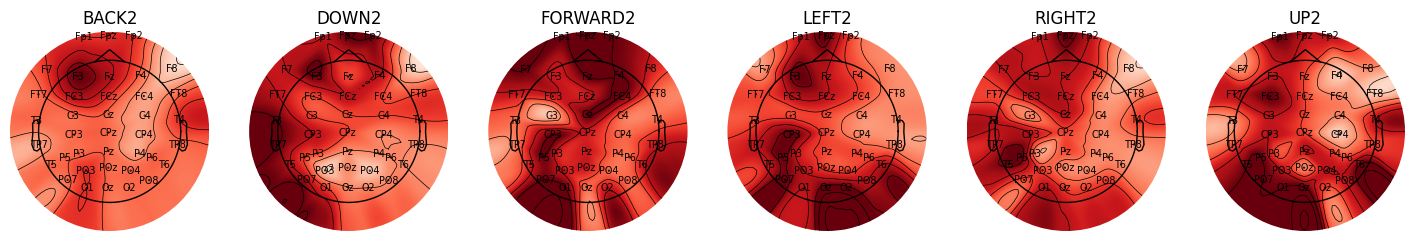

In [21]:
#построим на топокарте 
#let's plot a commonnes distribution on topomap
freqData = {item: [frequency[item][ch] if ch in getList(frequency[item]) else 0 for ch in epoData[0].ch_names] for item in frequency.keys()}
_, pos, _, _, _, _, _ = mne.viz.topomap._prepare_topomap_plot(epoData[0].info, 'eeg',sphere = 'auto')
fig, axes = plt.subplots(1, len(freqData.keys()), figsize = (18,10))
for idx, key in enumerate(freqData.keys()):
    axes[idx].set_title(key)
    mne.viz.plot_topomap(freqData[key], pos, names = epoData[0].ch_names, axes = axes[idx], show = False)
plt.show()
#fig.savefig('st<go.png')

In [84]:
#ранжируем список частот появления каналов, сохранив индексы (формат: (индекс, значение)). Индекс нужен, чтобы знать название канала
#sort the commoness list saving indices
sortFreq = {word: sorted(enumerate(freqData[word]), key=lambda i: i[1]) for word in freqData.keys()}
#теперь необходимо найти первый квартиль? или первые десять процентов наибольших значений?
#is it reasonable to look only for the most common channels? let's say the first quartile? or may be first 10%?
firstQ = {}
for word in sortFreq:
    m = 3 * (len(sortFreq[word]) + 1) // 4
    firstQ[word] = sortFreq[word][m:]
####найдем пересечения для значимых каналов####
#уникальные каналы
#find unique channels
uniCh = np.concatenate([[j[0] for j in firstQ[word]] for word in firstQ.keys()])
#пройдёмся по этим каналам и словам
#iterate through channels and words, reform data structure
chFreq = {}
for ch in uniCh:
    chFreq[epoData[0].ch_names[ch]] = []
    for word in firstQ.keys():
        for el in firstQ[word]:
            if ch == el[0]:
                chFreq[epoData[0].ch_names[ch]].append(word)

In [89]:
#представим полученные результаты в виде матрицы
#form the result as matrix hoping to group words by channels
matchMat = np.zeros((7, len(epoData[0].ch_names)))
for j_ind, ch in enumerate(epoData[0].ch_names):
    if ch in chFreq.keys():
        for i_ind, word in enumerate(firstQ.keys()):
            if word in chFreq[ch]:
                matchMat[i_ind,j_ind] = 1
            else:
                continue
    else:
        continue        

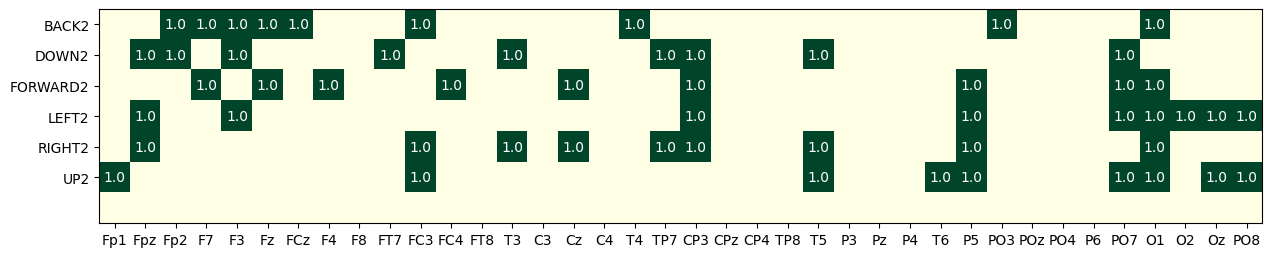

In [104]:
#построим
#plot the result
fig1, ax1 = plt.subplots(figsize = (15,5))
im = ax1.imshow(matchMat, cmap="YlGn")

ax1.set_xticks(np.arange(len(epoData[0].ch_names)), epoData[0].ch_names)
ax1.set_yticks(np.arange(len(firstQ.keys())), labels = firstQ.keys())

for i in range(len(epoData[0].ch_names)):
    for j in range(len(firstQ.keys())):
        if matchMat[j, i] != 0:
            text = ax1.text(i, j, matchMat[j, i],
                           ha="center", va="center", color="w")